In [21]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import dask.array as da
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [22]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [233]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

In [239]:
scenario = 'Azores_20201127'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    antenna_length=3.2,
    beam_pattern='phased_array',
    antenna_elements = 4,
    # era5_smoothing_window=15,
    # denoise = True,
    )

In [240]:
# test.open_data()
# test.querry_era5()
# test.wdir_from_era5()
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_leakage_velocity()
# test.compute_leakage_velocity_estimate()
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


## Misc

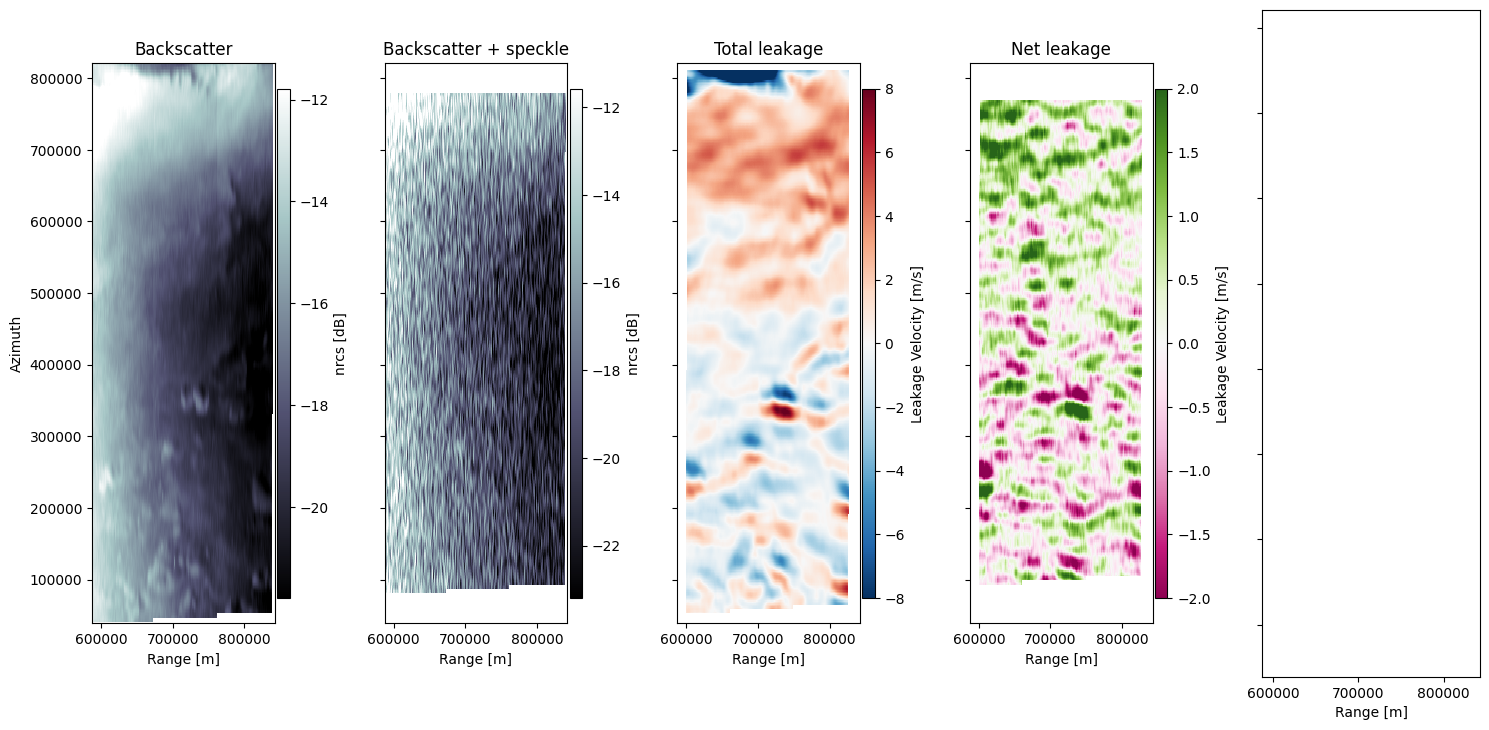

In [241]:
cbar_kwargs = {'shrink':0.7, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -8, 'vmax': 8, 'cmap' : 'RdBu_r'}
plot_leakage_net_kwargs = {'vmin': -2, 'vmax': 2, 'cmap' : 'PiYG'}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
nx = 5; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (15, 8), sharex=True, sharey=True)

(10*np.log10(test.data.nrcs_scat)).T.plot(ax= axes[0], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(10*np.log10(test.data.nrcs_scat_w_noise)).T.plot(ax= axes[1], 
                                                  **{'cmap': 'bone', **plot_kwargs},
                                                  cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
test.data.V_leakage_pulse_rg_subscene.T.plot(ax= axes[2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_leakage.T.plot(ax= axes[3],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})


titles = ['Backscatter', 'Backscatter + speckle', 'Total leakage', 'Net leakage']
x_labels = ['Range [m]'] * nx
y_labels = ['Azimuth'] + [''] * (nx - ny)
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

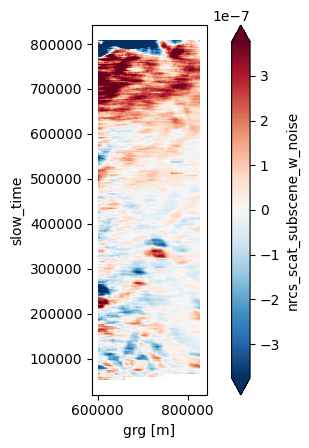

In [47]:
grad = test.data.nrcs_scat_subscene_w_noise.differentiate("slow_time")
ax = grad.T.plot(robust = True)
ax.axes.set_aspect('equal')

rˆ2: 0.799


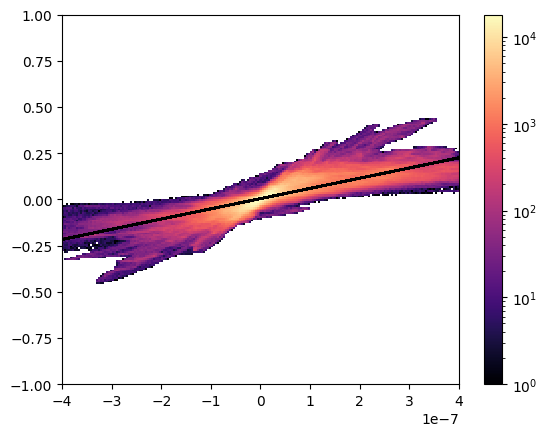

In [49]:
# plt.scatter(grad, test.data.V_leakage_pulse_rg_subscene.values.ravel(), s = 0.1, alpha = 0.01)
import matplotlib as mpl
from scipy import stats

# TODO find if linear regression using normalized gradients is 

x = grad.values.ravel()
y = test.data.V_leakage_pulse_rg_subscene.values.ravel()

mask = ~np.isnan(x) & ~np.isnan(y)


slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])

plt.plot(x[mask], intercept + slope*x[mask], '--k')
plt.hist2d(x, 
               y, 
               norm = mpl.colors.LogNorm(),
               range = [[-4e-07, 4e-07], [-1, 1]], 
               bins = 200,
               cmap = 'magma')
plt.colorbar()

print(f"rˆ2: {r_value**2:.3f}")